In [303]:
import numpy
import random
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [304]:
from datetime import datetime, timedelta
now = datetime.now().replace(second=0, microsecond=0) - timedelta(days=365)

In [305]:
ROOM_TEMP = 24.0

In [306]:
DESIGN_MIN_VOLTAGE = 2700  # mV
DESIGN_MAX_VOLTAGE = 4200  # mV

In [307]:
### FOR NORMAL DATA:
NORMAL_DISCHARGE_CURRENT = -3000  # mA
NORMAL_CHARGE_CURRENT = 5000  # mA

NORMAL_VOLTAGE_DROP_RATE = 0.13
NORMAL_VOLTAGE_GROW_RATE = 0.2

In [308]:
### FOR LOW POWER DATA:
LOW_DISCHARGE_CURRENT = -200  # mA

LOW_POWER_VOLTAGE_DROP_RATE = 0.02

In [309]:
### FOR SHORT DURATION DATA:
EARLY_MIN_VOLTAGE = 3800  # mV

In [310]:
def generate_discharge_charge_data(initial_temp, initial_current, initial_voltage, final_discharge_voltage, final_charge_voltage, voltage_drop_rate, voltage_grow_rate, cycle, directory, discharge_offline_gap=None, charge_offline_gap=None):
    global now

    path = Path(directory)
    path.mkdir(parents=True, exist_ok=True)
    with open(f"{str(path)}/data_{cycle}.csv","w") as f:
        f.write("TimeStamp,Temperature,Voltage,Current,Relative State of Charge\n")

        # initialisation
        temp = initial_temp
        voltage = initial_voltage
        current = initial_current
        const_power = voltage * current

        # starting state
        f.write(f"{now},"
                f"{temp:.1f},"
                f"{int(voltage)},"
                f"{0},"
                f"{int((voltage-DESIGN_MIN_VOLTAGE)/(DESIGN_MAX_VOLTAGE-DESIGN_MIN_VOLTAGE)*100)}\n")
        
        now += timedelta(minutes=1)


        # discharge first
        i = 0
        while voltage > final_discharge_voltage:
            frac = 1 - (voltage - final_discharge_voltage) / (initial_voltage - final_discharge_voltage)
            dv = (initial_voltage - final_discharge_voltage) * voltage_drop_rate * max(frac, 0.001)
            voltage -= random.gauss(dv, 0.2 * dv)
            if voltage < final_discharge_voltage:
                voltage = final_discharge_voltage
            current = const_power / voltage
            temp += random.uniform(0.01,0.07)

            if discharge_offline_gap is None or (not (i>discharge_offline_gap[0] and i<discharge_offline_gap[1])):
                f.write(f"{now},"
                        f"{temp:.1f},"
                        f"{int(voltage)},"
                        f"{int(current+random.gauss(0,1))},"
                        f"{int((voltage-DESIGN_MIN_VOLTAGE)/(DESIGN_MAX_VOLTAGE-DESIGN_MIN_VOLTAGE)*100)}\n")

            now += timedelta(minutes=1)
            i += 1


        # rest period
        for _ in range(5):
            voltage += random.gauss(1.5, 1)
            temp -= random.uniform(0.03,0.16)

            f.write(f"{now},"
                    f"{temp:.1f},"
                    f"{int(voltage)},"
                    f"{0},"
                    f"{int((voltage-DESIGN_MIN_VOLTAGE)/(DESIGN_MAX_VOLTAGE-DESIGN_MIN_VOLTAGE)*100)}\n")

            now += timedelta(minutes=1)


        # then charge to full again ready for next cycle
        i = 0
        while voltage < final_charge_voltage:
            dv = (final_charge_voltage - voltage) * voltage_grow_rate
            voltage += random.gauss(dv, 0.2 * dv)
            if voltage > 0.999 * final_charge_voltage:
                voltage = final_charge_voltage
            current = random.gauss(NORMAL_CHARGE_CURRENT, 0.01 * NORMAL_CHARGE_CURRENT)
            temp += random.uniform(0.01,0.07)

            if charge_offline_gap is None or (not (i>charge_offline_gap[0] and i<charge_offline_gap[1])):
                f.write(f"{now},"
                        f"{temp:.1f},"
                        f"{int(voltage)},"
                        f"{int(current+random.gauss(0,1))},"
                        f"{int((voltage-DESIGN_MIN_VOLTAGE)/(DESIGN_MAX_VOLTAGE-DESIGN_MIN_VOLTAGE)*100)}\n")

            now += timedelta(minutes=1)
            i += 1


        # rest period
        for i in range(5):
            voltage = random.gauss(final_charge_voltage, 0.0001 * final_charge_voltage)
            temp -= random.uniform(0.03,0.16)

            f.write(f"{now},"
                    f"{temp:.1f},"
                    f"{int(voltage)},"
                    f"{0},"
                    f"{int((voltage-DESIGN_MIN_VOLTAGE)/(DESIGN_MAX_VOLTAGE-DESIGN_MIN_VOLTAGE)*100)}\n")

            now += timedelta(minutes=1)

In [311]:
N_CYCLES = 24
SWITCH_POINT = 12

In [312]:
# normal
for i in range(N_CYCLES):
    generate_discharge_charge_data(ROOM_TEMP, NORMAL_DISCHARGE_CURRENT, DESIGN_MAX_VOLTAGE, DESIGN_MIN_VOLTAGE, DESIGN_MAX_VOLTAGE, NORMAL_VOLTAGE_DROP_RATE, NORMAL_VOLTAGE_GROW_RATE, i+1, "data/normal", discharge_offline_gap=(40,55) if i+1==N_CYCLES else None, charge_offline_gap=(10,20) if i+1==N_CYCLES else None)

In [313]:
# low power
for i in range(N_CYCLES):
    if i<SWITCH_POINT:
        generate_discharge_charge_data(ROOM_TEMP, NORMAL_DISCHARGE_CURRENT, DESIGN_MAX_VOLTAGE, DESIGN_MIN_VOLTAGE, DESIGN_MAX_VOLTAGE, NORMAL_VOLTAGE_DROP_RATE, NORMAL_VOLTAGE_GROW_RATE, i+1, "data/low_power")
    else:
        generate_discharge_charge_data(ROOM_TEMP, LOW_DISCHARGE_CURRENT, DESIGN_MAX_VOLTAGE, DESIGN_MIN_VOLTAGE, DESIGN_MAX_VOLTAGE, LOW_POWER_VOLTAGE_DROP_RATE, NORMAL_VOLTAGE_GROW_RATE, i+1, "data/low_power", discharge_offline_gap=(200,300) if i+1==N_CYCLES else None, charge_offline_gap=(10,20) if i+1==N_CYCLES else None)

In [314]:
# short duration
for i in range(N_CYCLES):
    if i<SWITCH_POINT:
        generate_discharge_charge_data(ROOM_TEMP, NORMAL_DISCHARGE_CURRENT, DESIGN_MAX_VOLTAGE, DESIGN_MIN_VOLTAGE, DESIGN_MAX_VOLTAGE, NORMAL_VOLTAGE_DROP_RATE, NORMAL_VOLTAGE_GROW_RATE, i+1, "data/short_duration")
    else:
        generate_discharge_charge_data(ROOM_TEMP, NORMAL_DISCHARGE_CURRENT, DESIGN_MAX_VOLTAGE, EARLY_MIN_VOLTAGE, DESIGN_MAX_VOLTAGE, NORMAL_VOLTAGE_DROP_RATE, NORMAL_VOLTAGE_GROW_RATE, i+1, "data/short_duration", discharge_offline_gap=(40,55) if i+1==N_CYCLES else None, charge_offline_gap=(10,20) if i+1==N_CYCLES else None)

/tmp/ipykernel_210586/2636687514.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(title=f"Cycle {N_CYCLES}")


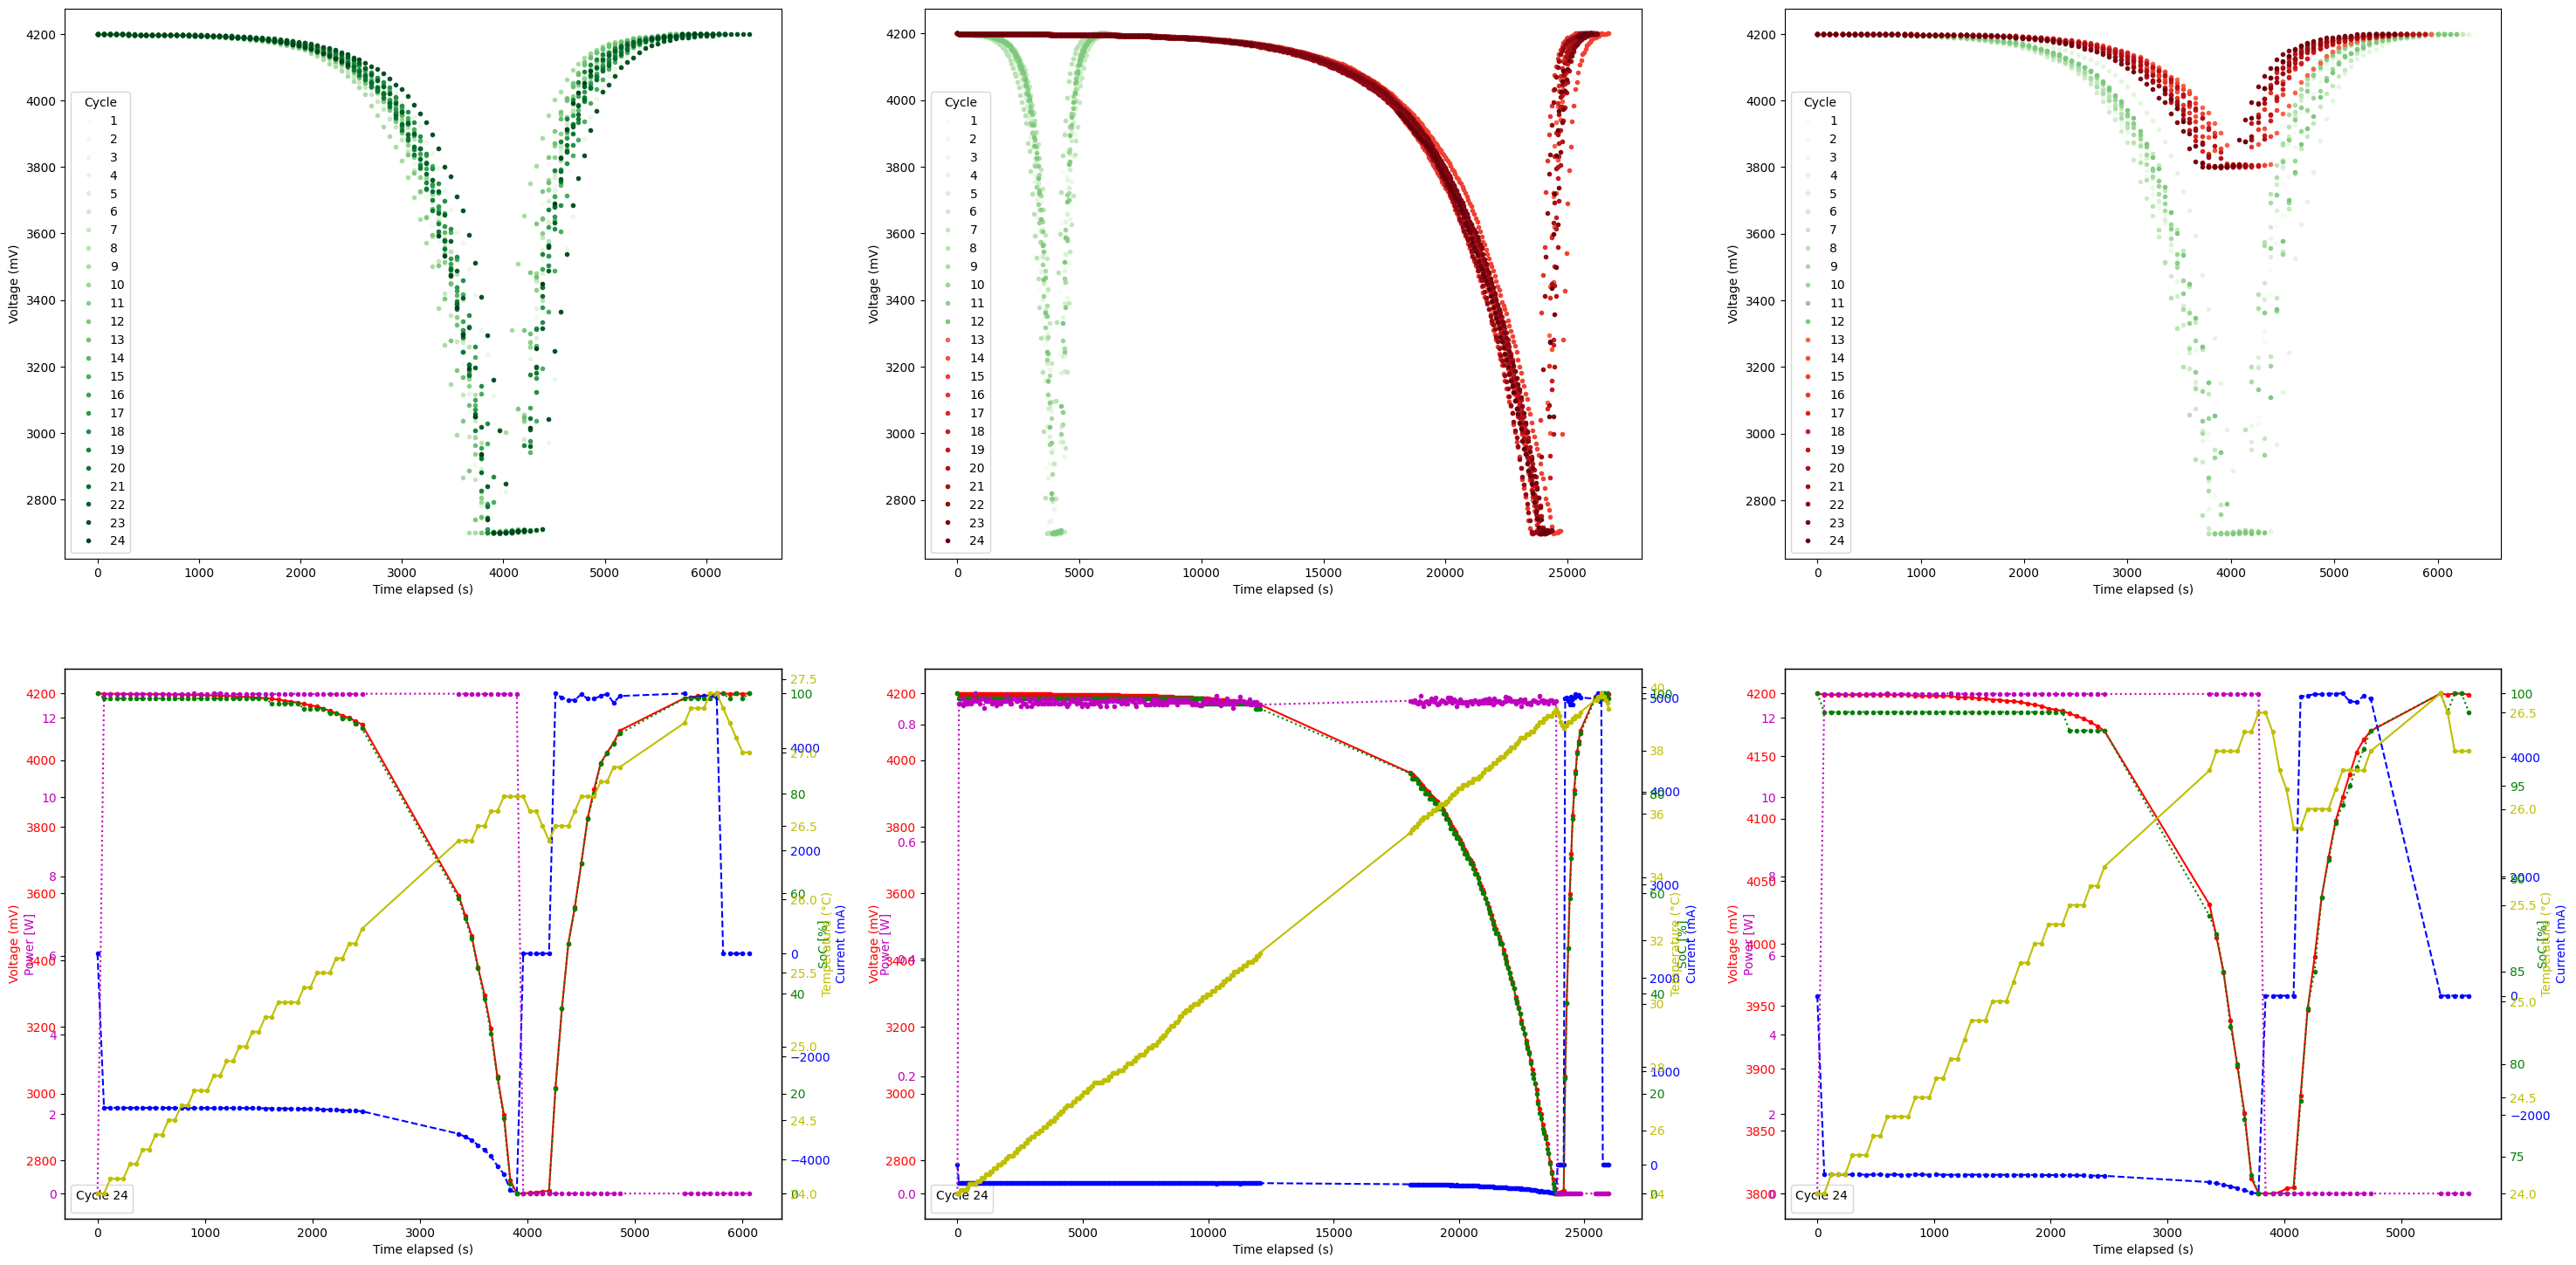

In [315]:
fig, axs = plt.subplots(2,3,figsize=(36,18))

green_cmap = cm.Greens
red_cmap = cm.Reds
norm = mcolors.Normalize(vmin=0, vmax=N_CYCLES-1)

for i in range(N_CYCLES):
    green = green_cmap(norm(i))
    red = red_cmap(norm(i))
    for path, j in zip(["normal", "low_power", "short_duration"], range(3)):
        timestamps, temps, voltages, currents, socs, powers = [], [], [], [], [], []
        with open(f"data/{path}/data_{i+1}.csv", "r") as f:
            for l in f:
                if l.startswith("TimeStamp"): continue

                timestamp, temp, voltage, current, soc = l.strip().split(",")
                timestamps.append(datetime.fromisoformat(timestamp))
                temps.append(float(temp))
                voltages.append(float(voltage))
                currents.append(float(current))
                socs.append(int(soc))
                powers.append(0 if float(current)>0 else abs(float(current)/1000) * float(voltage)/1000)

        times = [(t - timestamps[0]).total_seconds() for t in timestamps]

        axs[0][j].plot(times, voltages, color=green if path =="normal" or i<SWITCH_POINT else red, label=i+1, linewidth=0, marker=".")
        axs[0][j].set_xlabel("Time elapsed (s)")
        axs[0][j].set_ylabel("Voltage (mV)")
        axs[0][j].legend(title="Cycle")
    
        if i==N_CYCLES-1:
            ax1 = axs[1][j]
            ax1.plot(times, voltages, color="r", marker=".")
            ax1.set_xlabel("Time elapsed (s)")
            ax1.set_ylabel("Voltage (mV)", color="r")
            ax1.tick_params(axis="y", labelcolor="r")

            ax2 = ax1.twinx()
            ax2.plot(times, currents, color="b", marker=".", linestyle="--")
            ax2.set_ylabel("Current (mA)", color="b")
            ax2.tick_params(axis="y", labelcolor="b")

            ax3 = ax1.twinx()
            ax3.plot(times, socs, color="g", marker=".", linestyle=":")
            ax3.set_ylabel("SoC [%]", color="g")
            ax3.tick_params(axis="y", labelcolor="g")

            ax4 = ax1.twinx()
            ax4.yaxis.set_label_position("left")
            ax4.yaxis.tick_left()
            ax4.plot(times, powers, color="m", marker=".", linestyle=":")
            ax4.set_ylabel("Power [W]", color="m")
            ax4.tick_params(axis="y", labelcolor="m")

            ax5 = ax1.twinx()
            ax5.plot(times, temps, color="y", marker=".")
            ax5.set_ylabel("Temperature (°C)", color="y")
            ax5.tick_params(axis="y", labelcolor="y")

            ax1.legend(title=f"Cycle {N_CYCLES}")
